In [93]:
import numpy as np
import pandas as pd
import pickle as pkl
import scanpy as sc
import torch 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from omegaconf import OmegaConf
from matplotlib import rcParams
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule

FIGSIZE=(3,3)
rcParams['figure.figsize']=FIGSIZE
import warnings
warnings.filterwarnings('ignore')

In [73]:
def plot_umap_by_X_value(adata, column, selected):
    condition = (adata.obs[column] == selected)
    adata.obs['gene_selection'] = 'others'  # Set default color to gray
    adata.obs.loc[condition, 'gene_selection'] = selected
    plt.figure(figsize=(5,5))
    sc.pl.umap(adata, color=['gene_selection'], groups=selected, show=False, alpha=0.8)  # Adjust the palette as needed
    plt.show()

In [74]:
metadata_cpg0000 = pd.read_csv("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_gene2vec.csv",
                              index_col=0)
metadata_cpg0000_trt = metadata_cpg0000.loc[metadata_cpg0000.STATE=="trt"]

In [75]:
metadata_cpg0000_cpd = metadata_cpg0000_trt.drop_duplicates(subset="BROAD_SAMPLE", keep="last").sort_values(by="BROAD_SAMPLE")

In [76]:
gene_unique = np.unique(metadata_cpg0000_cpd.GENE)

In [227]:
metadata_cpg0000_cpd = metadata_cpg0000_cpd.set_index("BROAD_SAMPLE")

Collect embeddings

In [78]:
pert_embeddings_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240303_a1c733a1-bd96-4fc9-8d94-dfd0f7c3a296_cpg0000_total_large_transported/checkpoint/000018_embeddings.ckpt"
cond_embeddings_path = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240303_a1c733a1-bd96-4fc9-8d94-dfd0f7c3a296_cpg0000_total_large_transported/checkpoint/000001_condition_embeddings.ckpt"

In [79]:
pert_embeddings = torch.load(pert_embeddings_path)
cond_embeddings = torch.load(cond_embeddings_path)

embeddings here are frozen

In [80]:
print(pert_embeddings["embedding_matrix"]['0.weight'].shape)
print(pert_embeddings["embedding_matrix"]['1.weight'].shape)
print(pert_embeddings["embedding_matrix"]['2.weight'].shape)

torch.Size([296, 328])
torch.Size([296, 1224])
torch.Size([155, 456])


## Initialize model 

In [81]:
import yaml

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config/cpg0000_mltimodal.yaml", "r") as file:
    config = yaml.safe_load(file)

args = OmegaConf.create(config)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240303_a1c733a1-bd96-4fc9-8d94-dfd0f7c3a296_cpg0000_total_large_transported"

In [136]:
dataloader = CellDataLoader(args)
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(18)
solver = solver.cuda()

{'CRISPR': 328, 'Compound': 1224, 'ORF': 456}
Number of parameters in generator: 24102789
Number of parameters in style_encoder: 14314208
Number of parameters in discriminator: 14681003
Number of parameters in mapping_network: 67232
Initializing embedding_matrix...
Initializing condition_embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): ModuleList(
    (0): Embedding(296, 328)
    (1): Embedding(296, 1224)
    (2): Embedding(155, 456)
  )
  (condition_embedding_matrix): Embedding(3, 10)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1

## CREATE THE OBS IN THE ANNDATA

In [105]:
mol2id = dataloader.mol2id

In [225]:
metadata_cpg0000_cpd

BROAD_SAMPLE           SAMPLE_KEY       PLATE WELL  \
434777  BRD-A00827783-001-24-6  BR00117012_F08_7_69  BR00117012  F08   
435073  BRD-A01078468-001-14-8  BR00117013_A04_4_10  BR00117013  A04   
434945  BRD-A07207424-001-14-0  BR00117010_O13_3_47  BR00117010  O13   
434221  BRD-A08187463-001-12-9  BR00117010_F14_1_32  BR00117010  F14   
433309  BRD-A09722536-002-18-0  BR00117012_P14_8_71  BR00117012  P14   
...                        ...                  ...         ...  ...   
435133      ccsbBroad304_14931  BR00118039_M12_6_36  BR00118039  M12   
431824      ccsbBroad304_14932  BR00118040_L19_1_49  BR00118040  L19   
433864      ccsbBroad304_14989  BR00118040_F07_1_55  BR00118040  F07   
432509      ccsbBroad304_16173  BR00118040_F08_7_85  BR00118040  F08   
434689      ccsbBroad304_16175  BR00118040_I10_4_15  BR00118040  I10   

       PERT_TYPE          CPD_NAME STATE     ANNOT    GENE  \
434777  Compound        dyphylline   trt  Compound   PDE7A   
435073  Compound         hexestrol   trt  Compound  AKR1C1   
434945  Compound        Ro-20-1724   trt  Compound   PDE3A   
434221  Compound      racecadotril   trt  Compound     MME   
433309  Compound  cyclophosphamide   trt  Compound  CYP2A6   
...          ...               ...   ...       ...     ...   
435133       ORF            DYRK1B   trt       ORF  DYRK1B   
431824       ORF             AURKB   trt       ORF   AURKB   
433864       ORF             CHEK2   trt       ORF   CHEK2   
432509       ORF              KRAS   trt       ORF    KRAS   
434689       ORF              BRAF   trt       ORF    BRAF   

                                                 SEQUENCE  SPLIT  
434777                   Cn1c2ncn(CC(O)CO)c2c(=O)n(C)c1=O  train  
435073                   CCC(C(CC)c1ccc(O)cc1)c1ccc(O)cc1  train  
434945                      CCCCOc1cc(CC2CNC(=O)N2)ccc1OC  train  
434221         CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1   test  
433309                            ClCCN(CCCl)P1(=O)NCCCO1  train  
...                                                   ...    ...  
435133  atggccgtcccaccgggccatggtcccttctctggcttcccagggc...  train  
431824  atggcccagaaggagaactcctacccctggccctacggccgacaga...  train  
433864  atgtctcgggagtcggatgttgaggctcagcagtctcatggcagca...  train  
432509  atgactgaatataaacttgtggtagttggagctgttggcgtaggca...  train  
434689  atggcggcgctgagcggtggcggtggtggcggcgcggagccgggcc...   test  

[747 rows x 11 columns]

In [319]:
annot = {"PERT_NAME": [],
         "PERT_TYPE": [], 
         "GENE": []}

X_embeddings = []

# Common latent observation
z_common = torch.randn(1, 1000, args.z_dimension).mean(1).cuda()
# Iterate over type of perturbation and its id
for i, pert_type in enumerate(mol2id):
    # Iterate over mols
    for mol in mol2id[pert_type]:
        annot["PERT_TYPE"].append(pert_type)
        annot["PERT_NAME"].append(mol)
        annot["GENE"].append(metadata_cpg0000_cpd.loc[mol, "GENE"])
        
        emb =  solver.embedding_matrix[i](torch.tensor(mol2id[pert_type][mol]).cuda()).unsqueeze(0)
        cond_emb = solver.condition_embedding_matrix(torch.tensor(i).cuda()).unsqueeze(0)
        concat_emb = torch.cat([emb, cond_emb,z_common], dim=1)
        with torch.no_grad():
            pert_emb = solver.mapping_network(concat_emb, None,i)
        X_embeddings.append(pert_emb)

X_embeddings = torch.cat(X_embeddings, dim=0)
annot = pd.DataFrame(annot)

In [320]:
adata = sc.AnnData(X=X_embeddings.detach().cpu().numpy(), 
                  obs=annot)

In [321]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

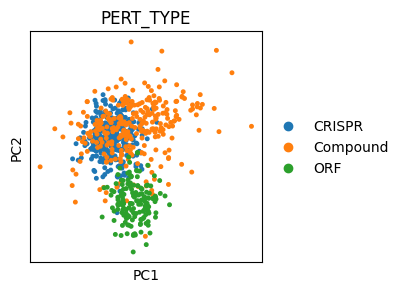

In [329]:
sc.pl.pca(adata, color="PERT_TYPE", s=50)

In [327]:
unique_genes = np.unique(metadata_cpg0000_cpd.GENE)

ABL1


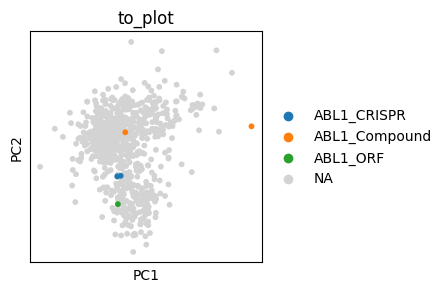

ADA


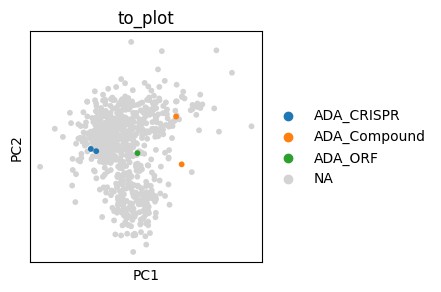

ADH1C


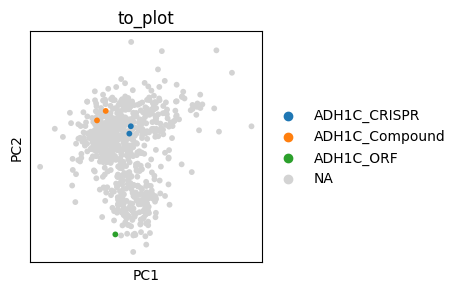

ADORA2A


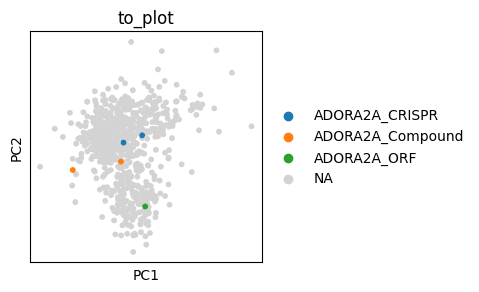

ADRA2B


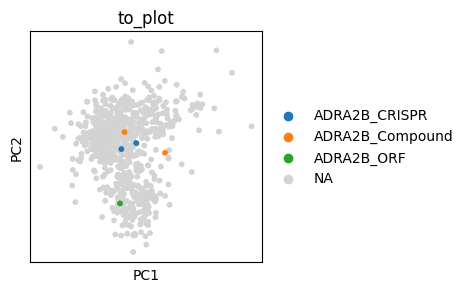

AGER


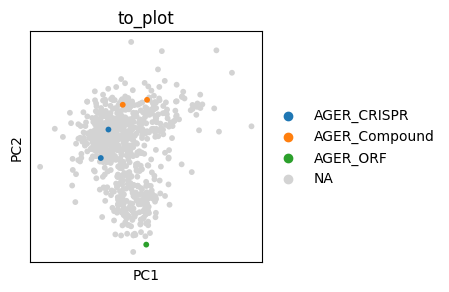

AKR1B1


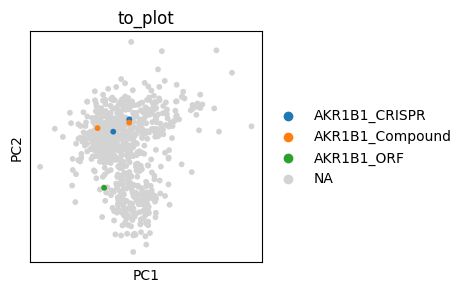

AKR1C1


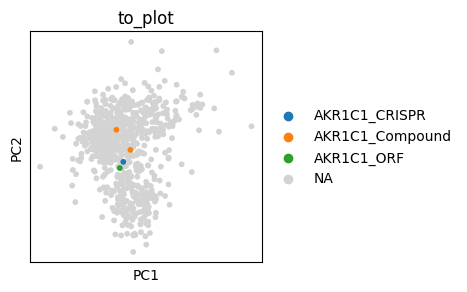

AKT1


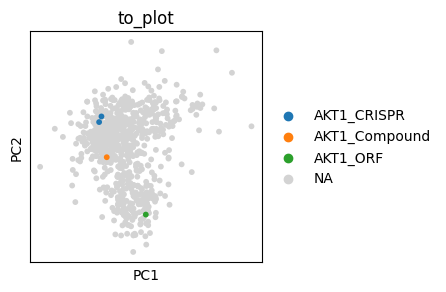

ALDH2


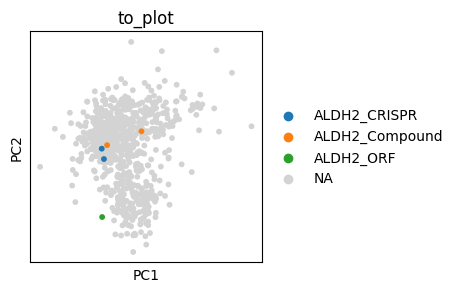

ALK


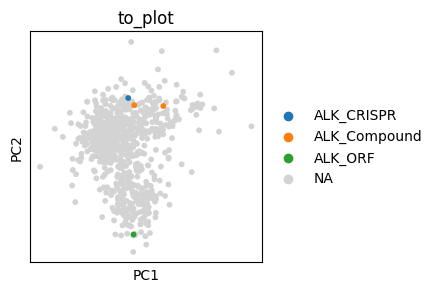

ANXA1


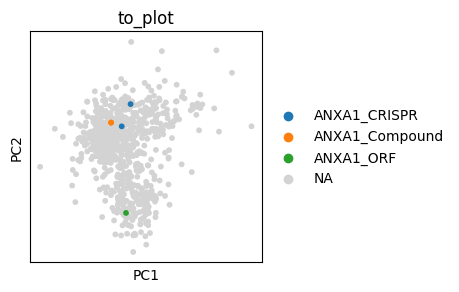

ASIC1


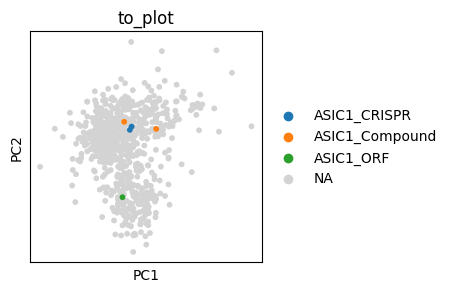

ATM


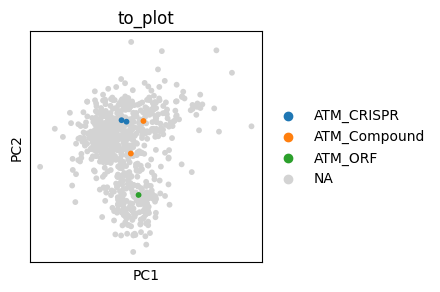

AURKB


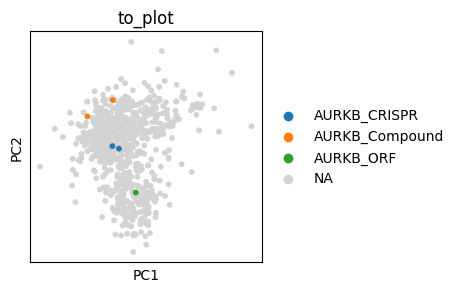

AVPR1A


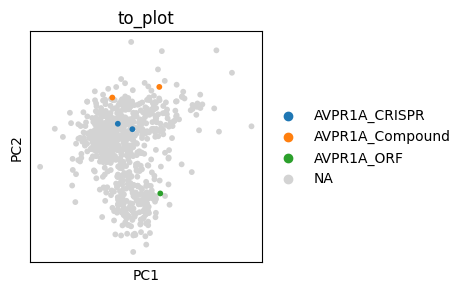

BAX


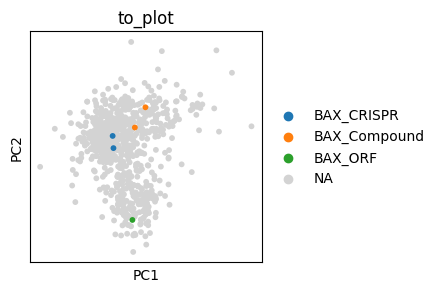

BRAF


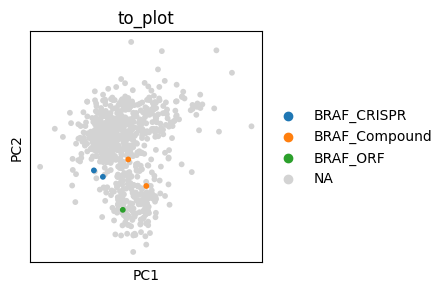

BRD4


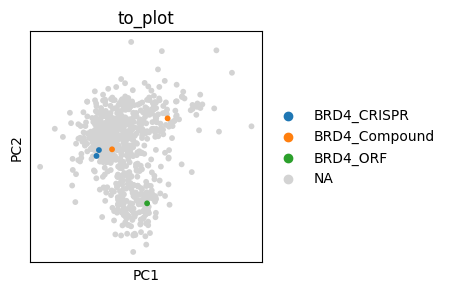

BTK


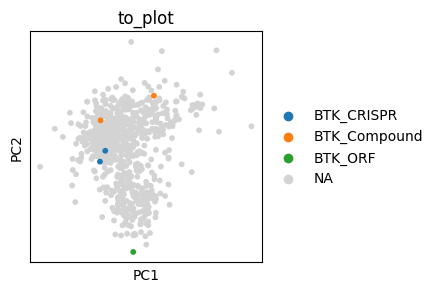

CA14


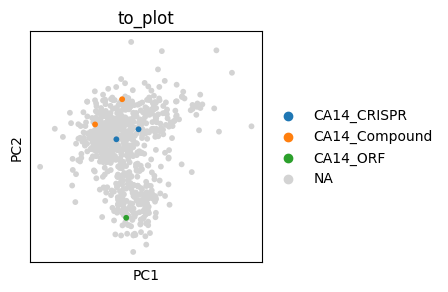

CA5A


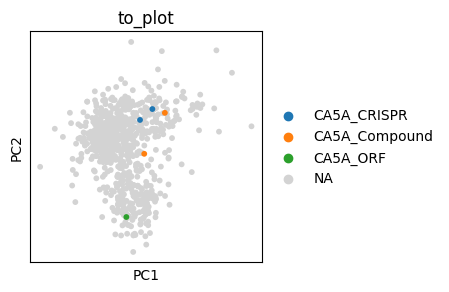

CACNA2D3


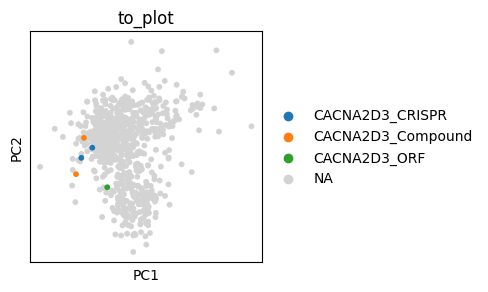

CACNB4


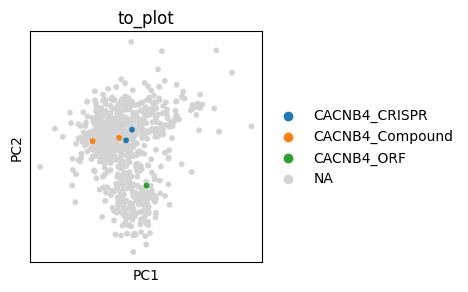

CACNG1


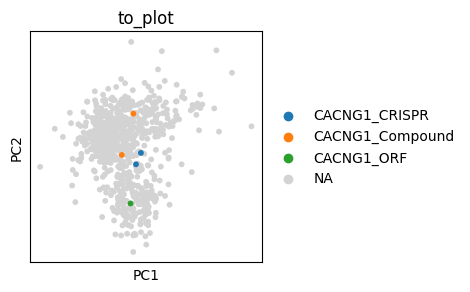

CASP3


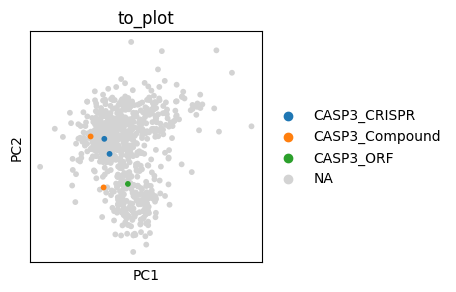

CCND1


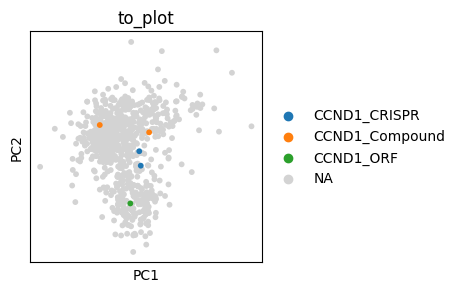

CCR1


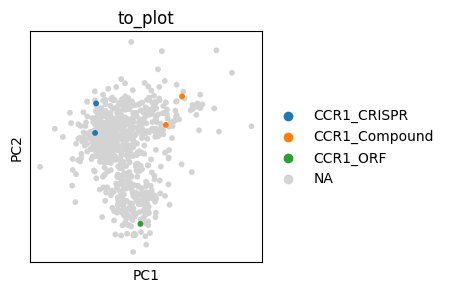

CDC25A


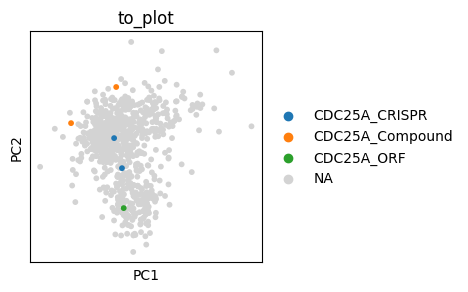

CDK2


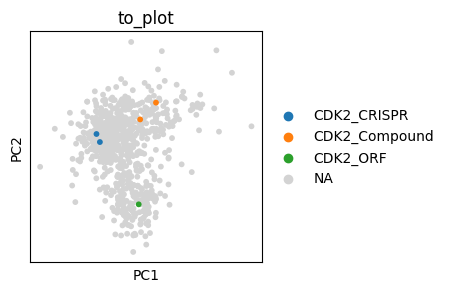

CDK4


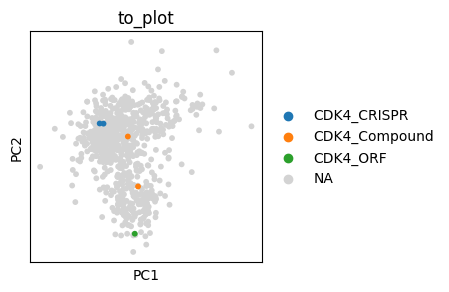

CDK7


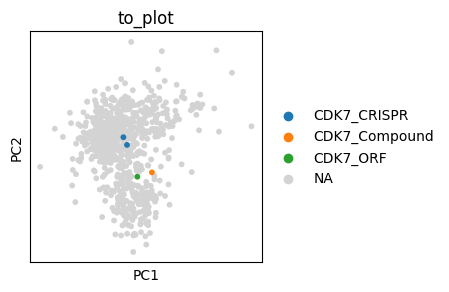

CDK9


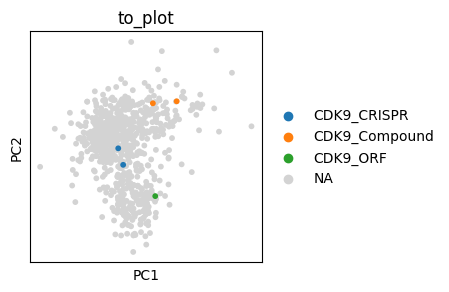

CHEK2


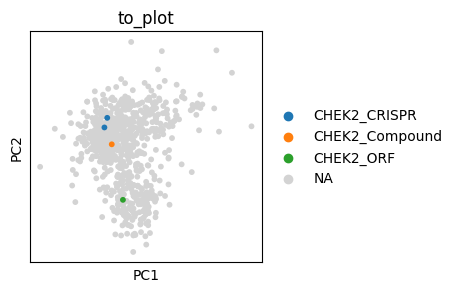

CHRM2


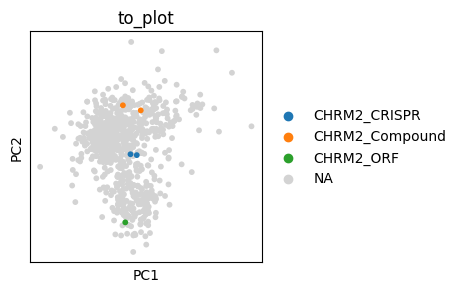

CHRM3


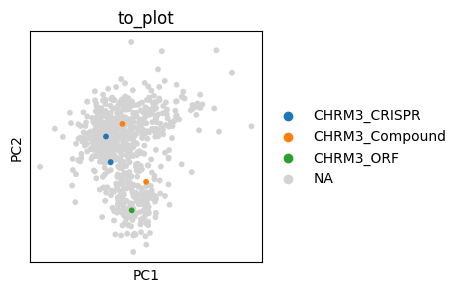

CLK1


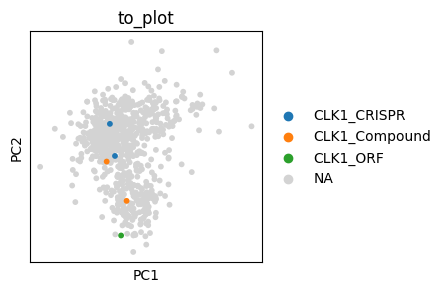

COMT


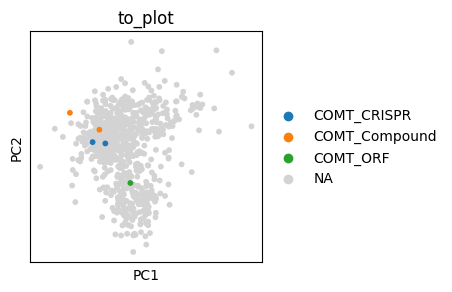

CSF1R


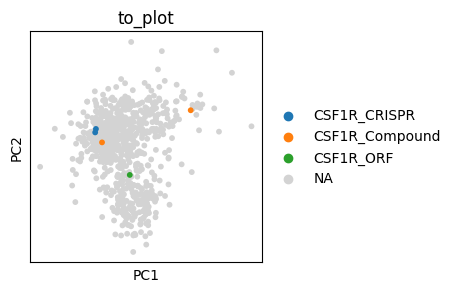

CSK


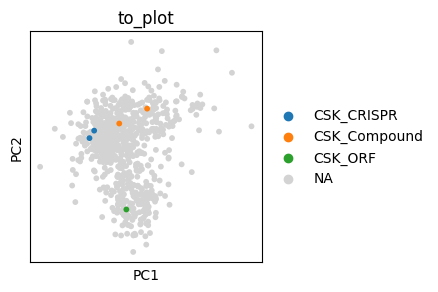

CTSG


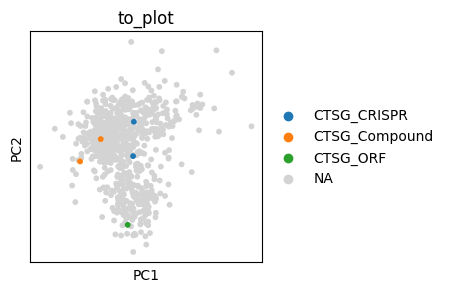

CYP1A2


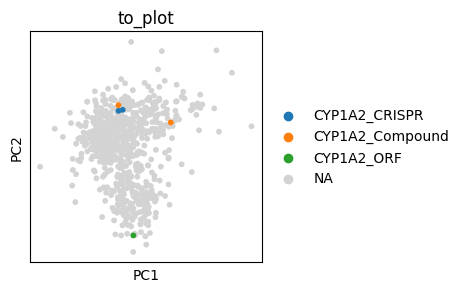

CYP2A6


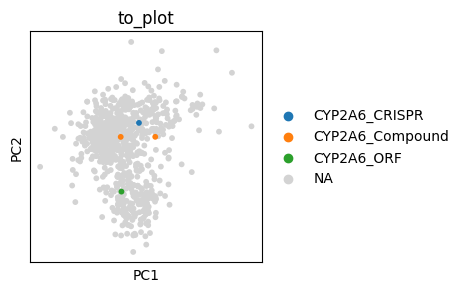

CYP3A4


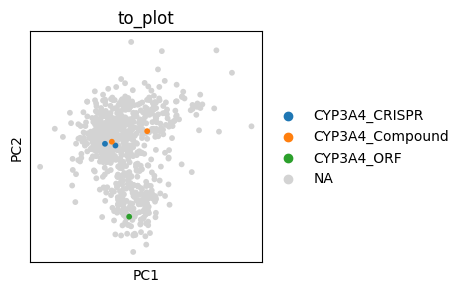

DCK


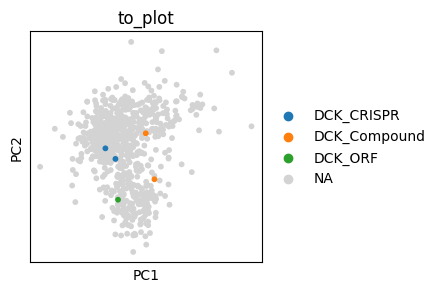

DDR2


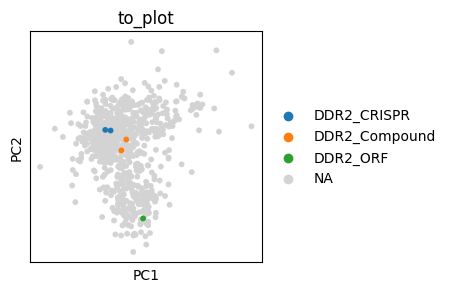

DHH


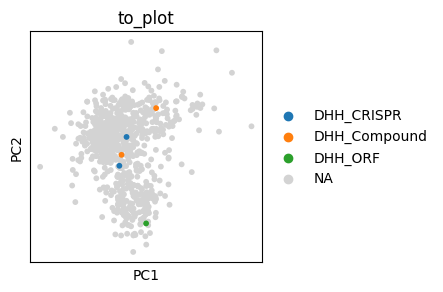

DNMT3A


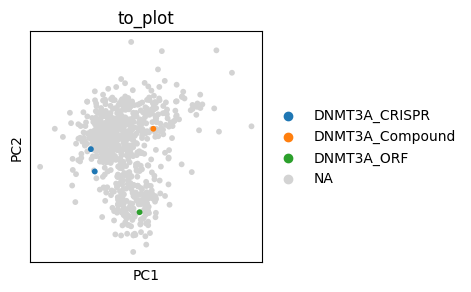

DYRK1B


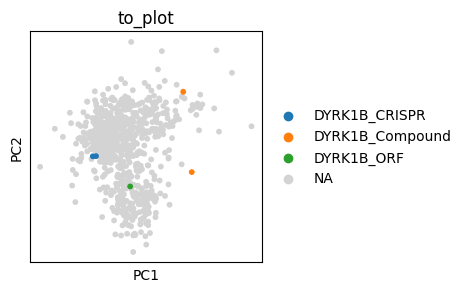

EDNRB


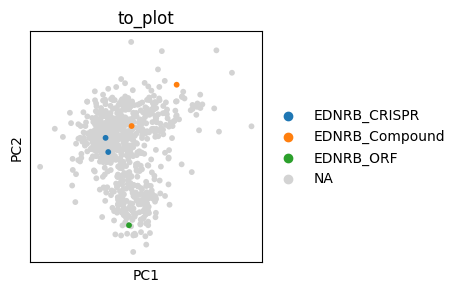

ELANE


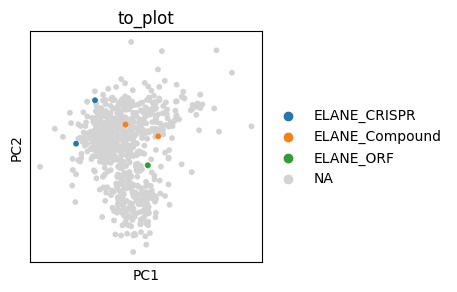

ERBB2


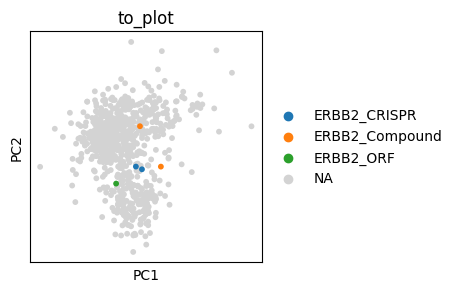

EZH2


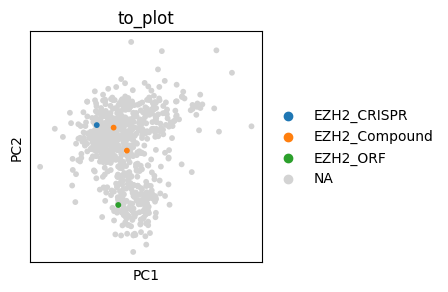

F10


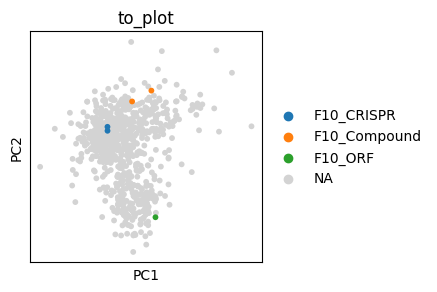

FFAR2


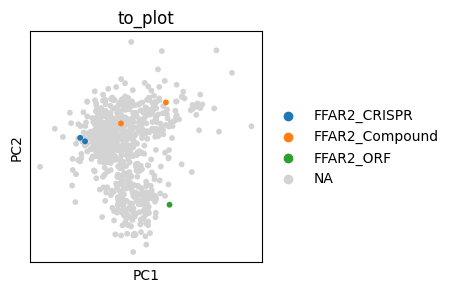

FFAR4


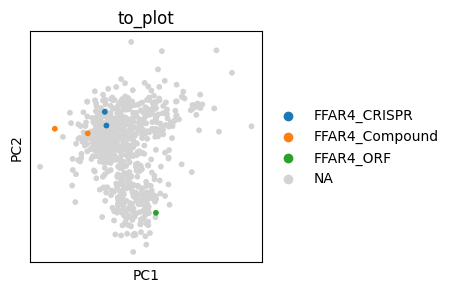

FGF1


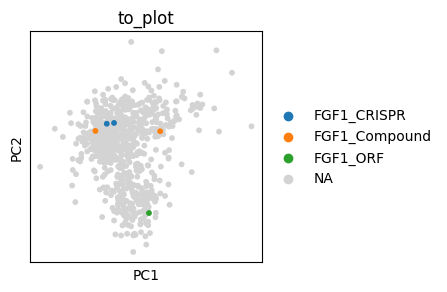

FLT3


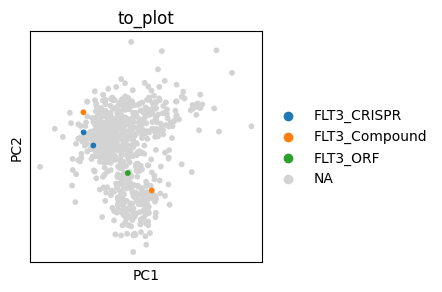

FOXM1


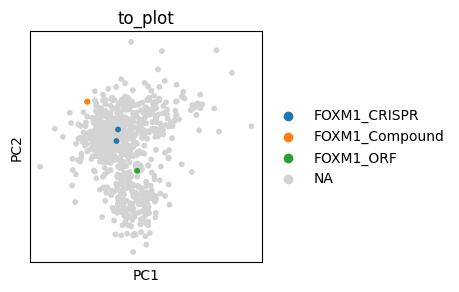

FPR1


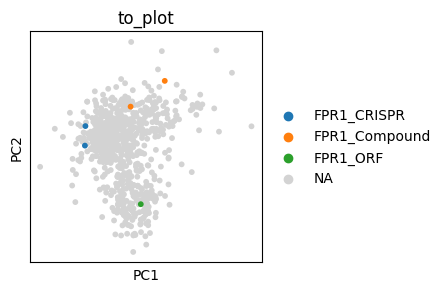

GAA


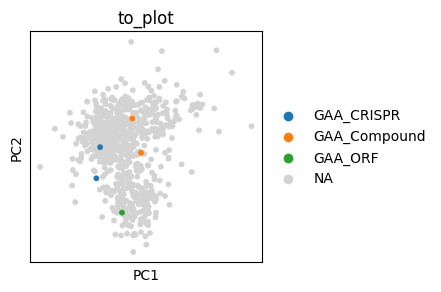

GABRB2


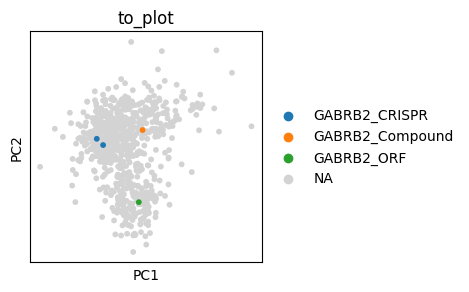

GHSR


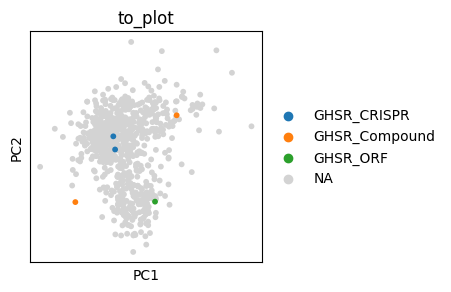

GJB4


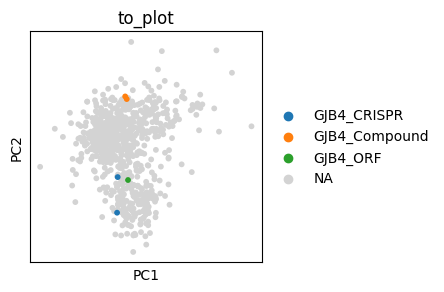

GLRA3


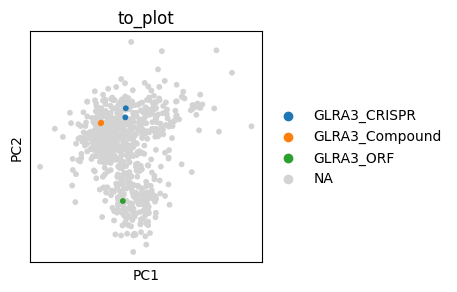

GPR55


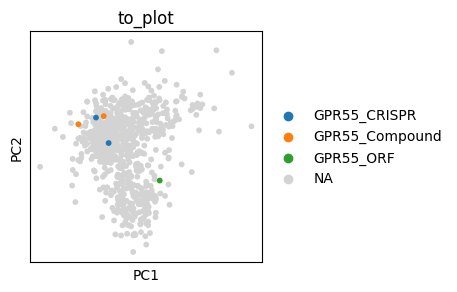

GRIN2A


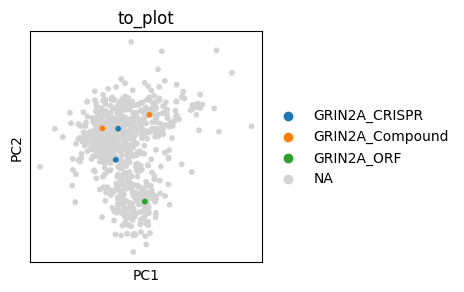

HBB


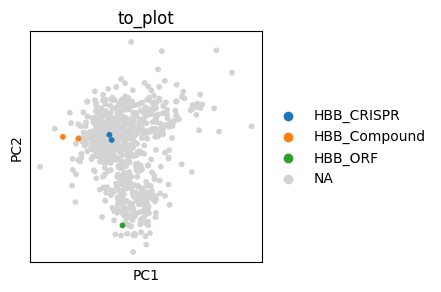

HCK


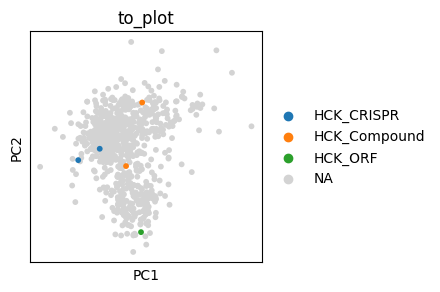

HDAC3


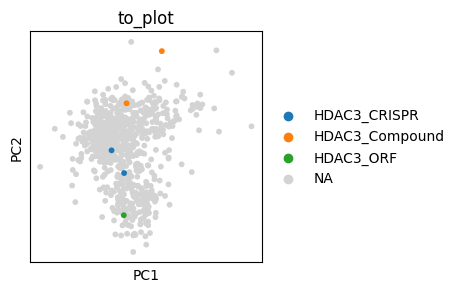

HDAC6


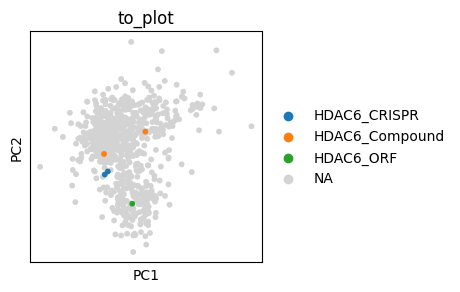

HIF1A


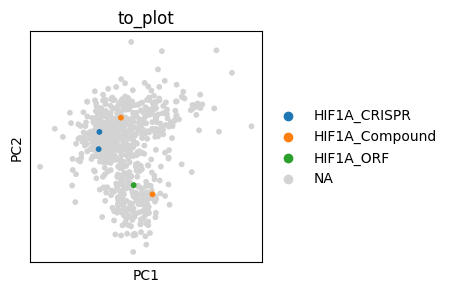

HPGDS


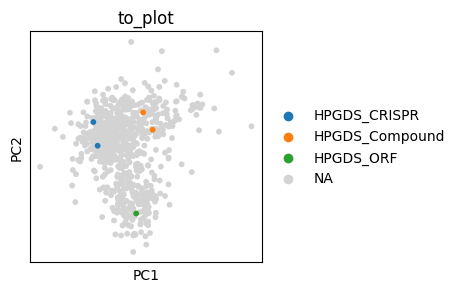

HRH4


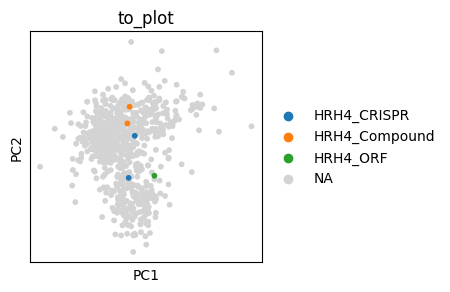

HSD11B1


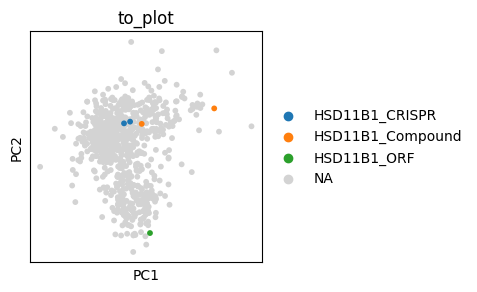

HSP90AA1


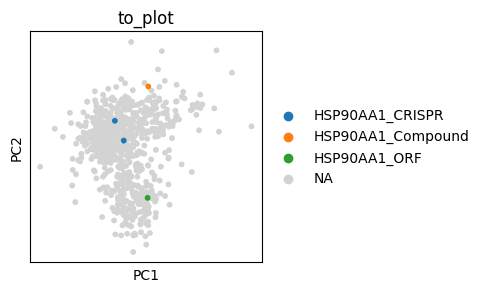

HSP90AB1


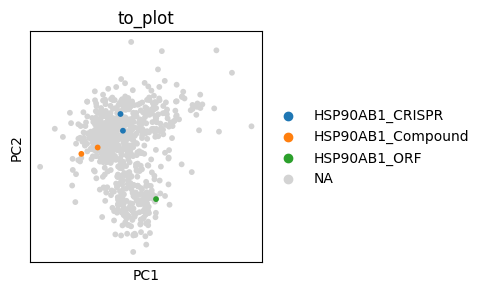

HTR2C


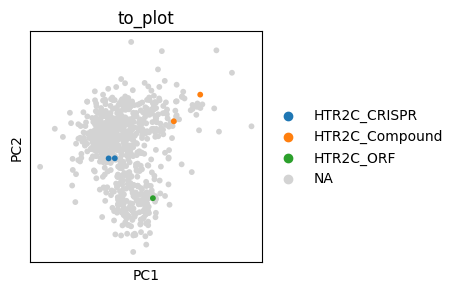

HTR3A


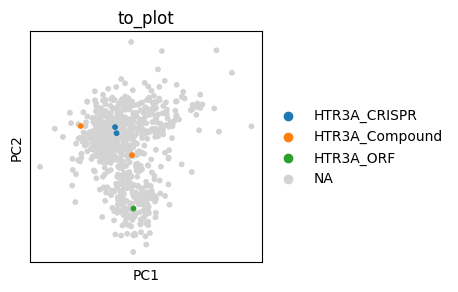

ICAM1


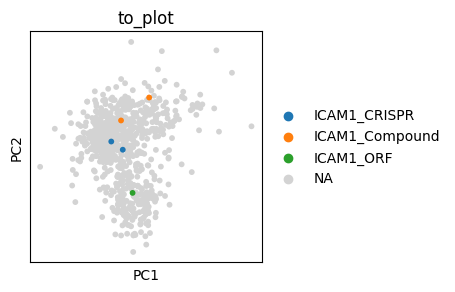

IGF1R


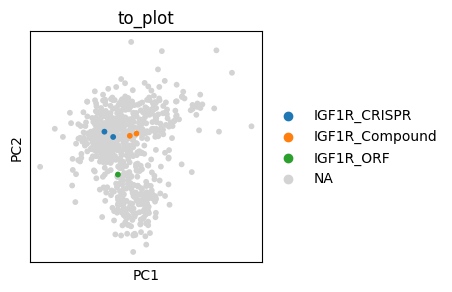

IL1B


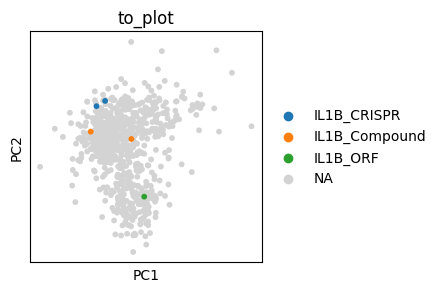

IMPDH1


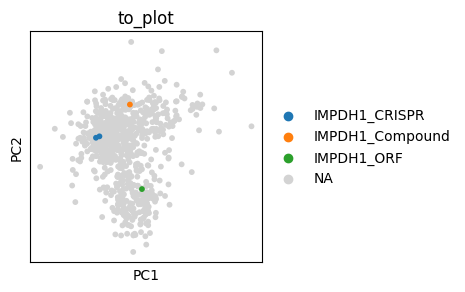

ITGB2


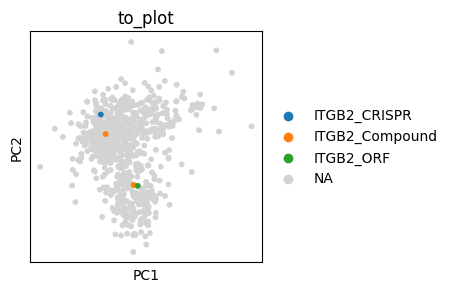

JAK1


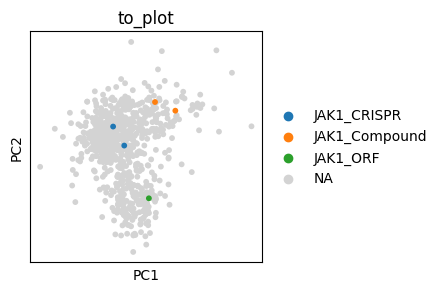

KCNH7


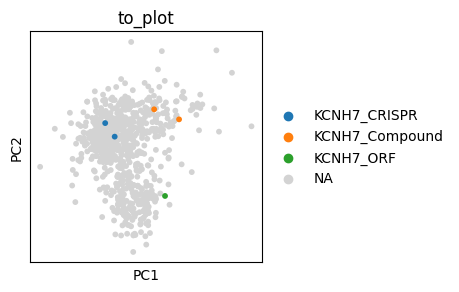

KCNJ1


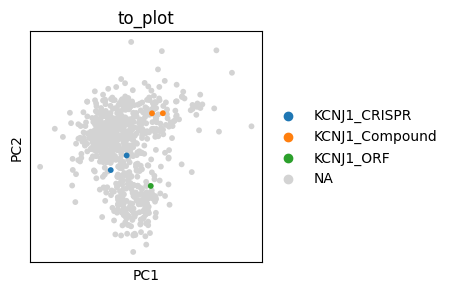

KCNK1


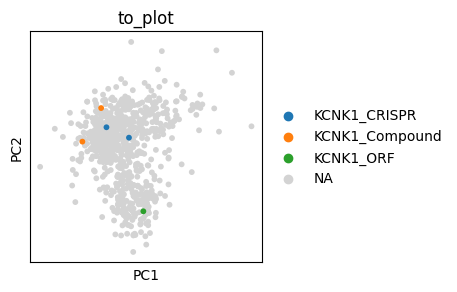

KCNMA1


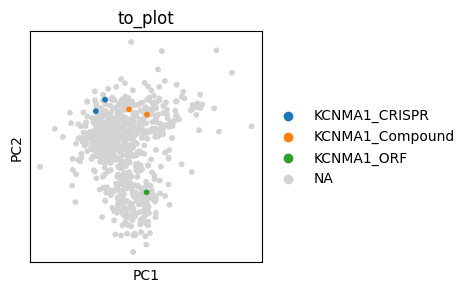

KCNN1


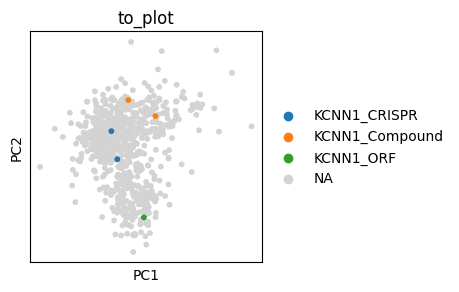

KCNN4


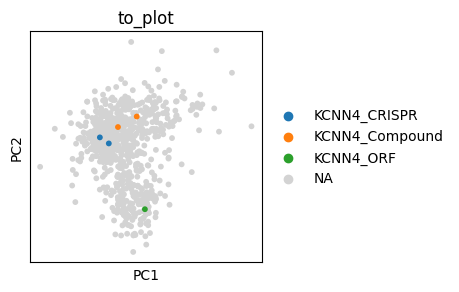

KCNQ2


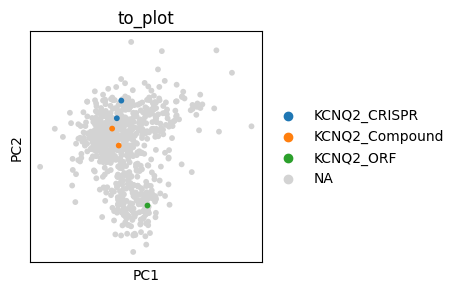

KCTD16


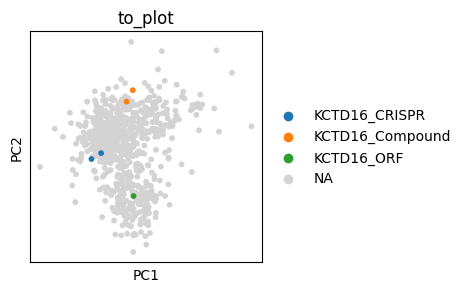

KDR


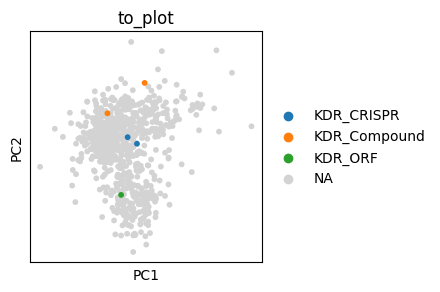

KRAS


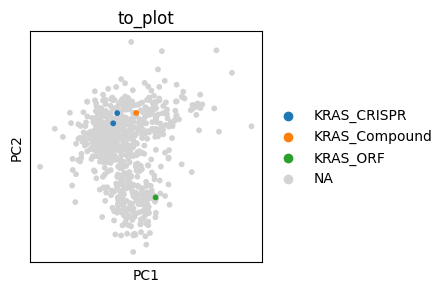

LCK


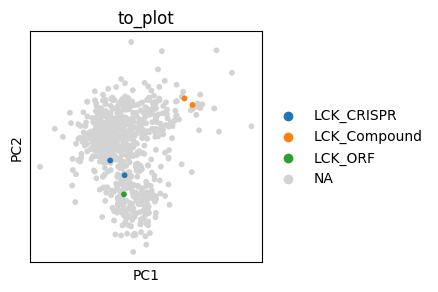

LPAR1


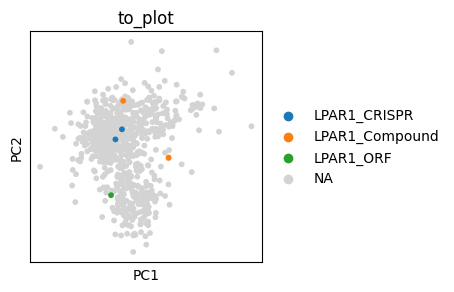

LYN


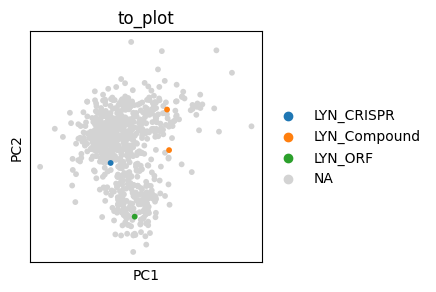

MAPK14


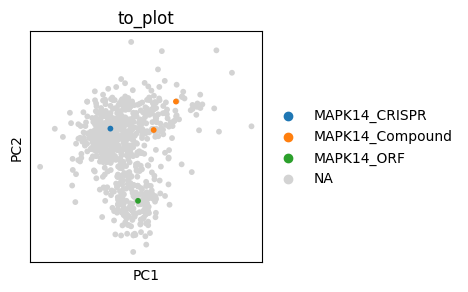

MAPK8


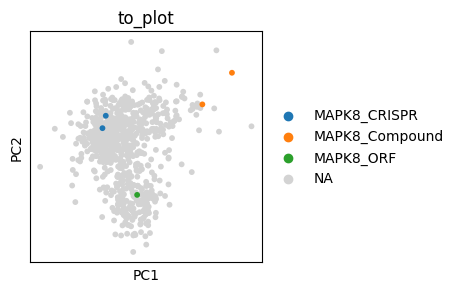

MET


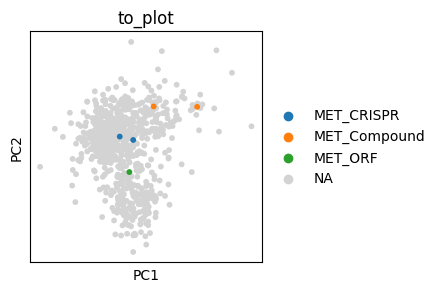

MME


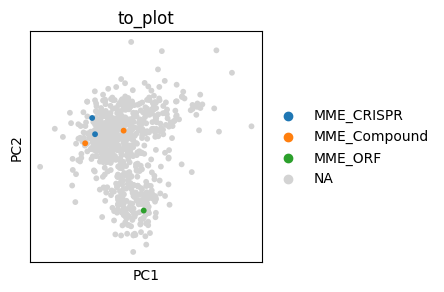

MMP2


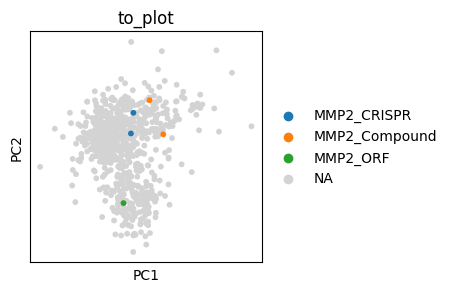

NAMPT


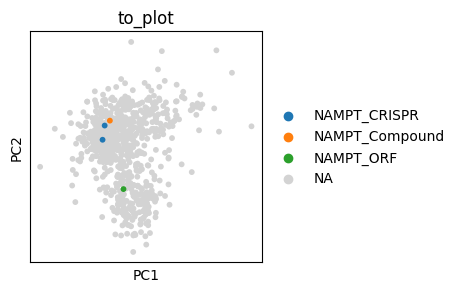

NTRK1


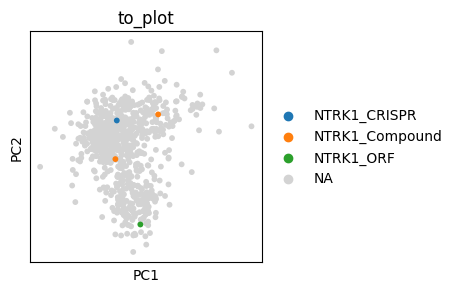

OPRL1


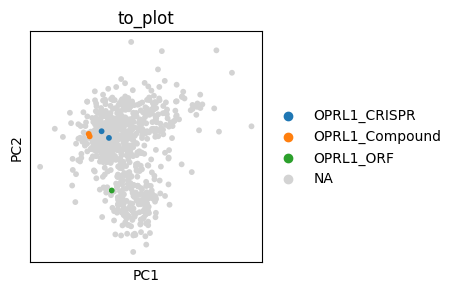

OPRM1


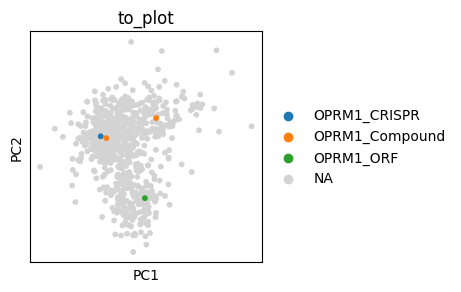

P2RY12


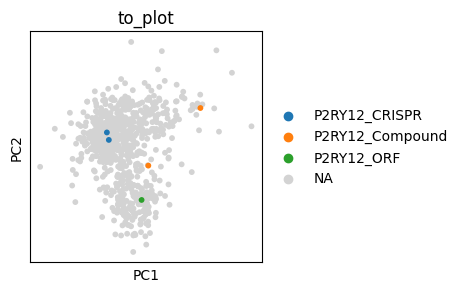

PAK1


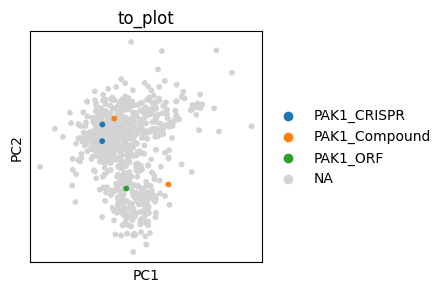

PAK4


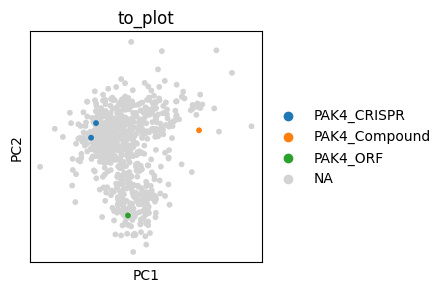

PARP3


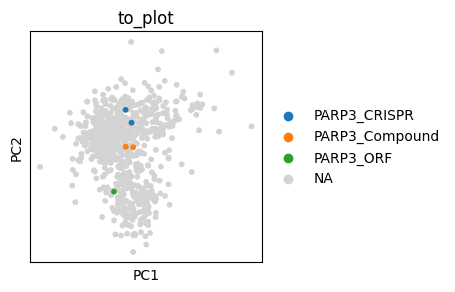

PDE3A


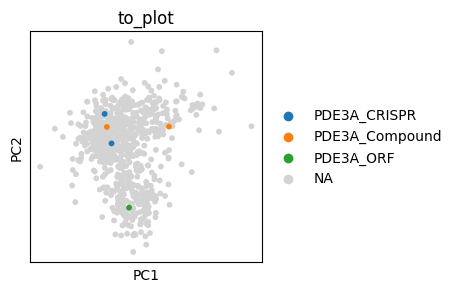

PDE4D


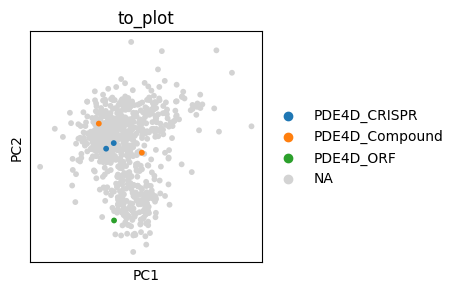

PDE7A


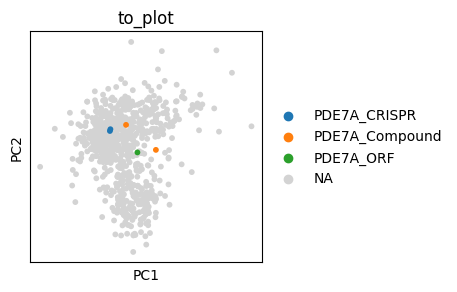

PDPK1


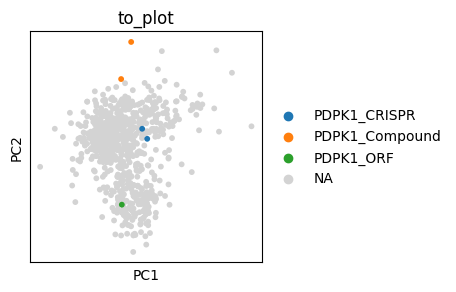

PIK3CG


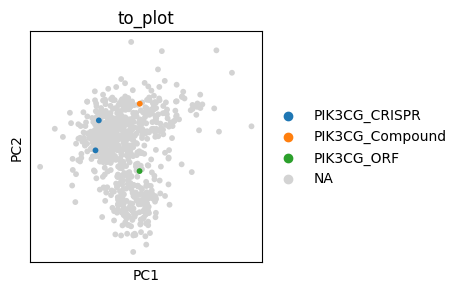

PLA2G1B


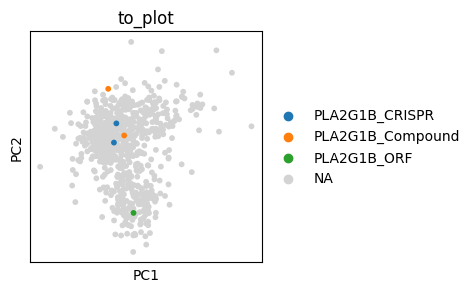

PLD1


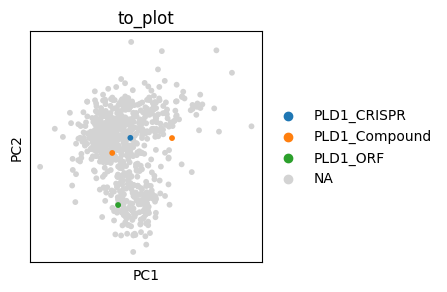

PLK1


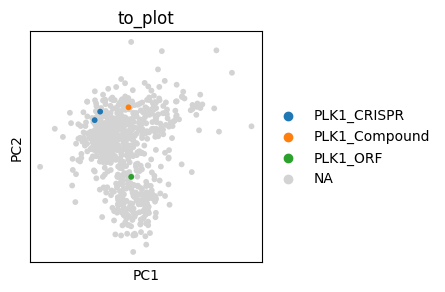

PNLIP


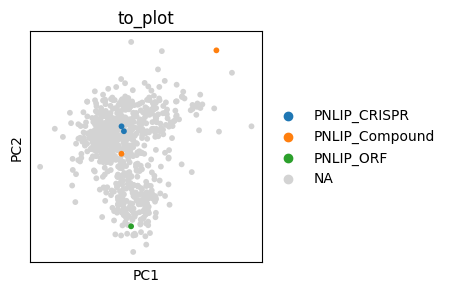

PORCN


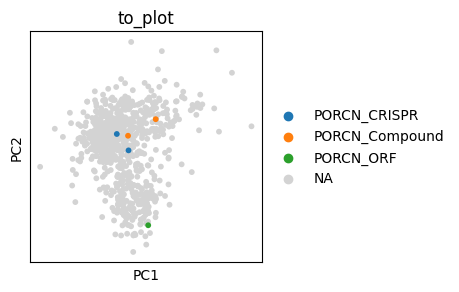

PPARD


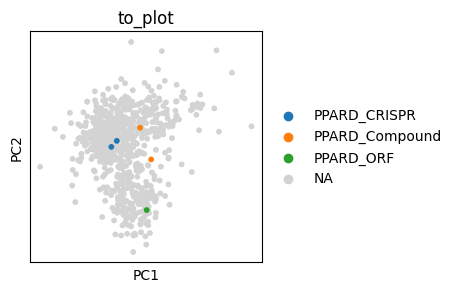

PPAT


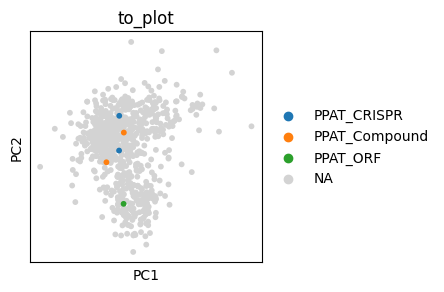

PRKCB


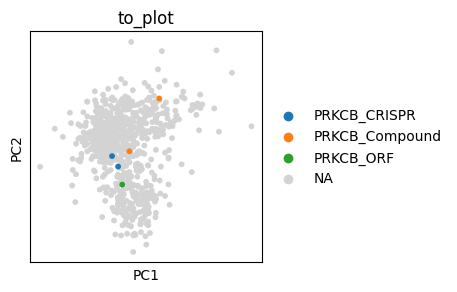

PRKCE


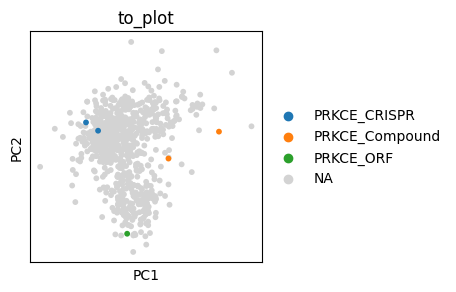

PTGIR


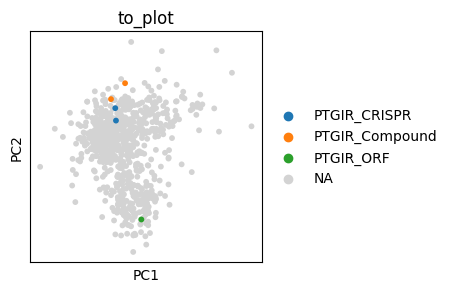

PTGIS


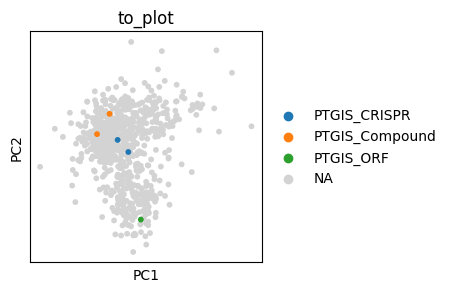

PTK2B


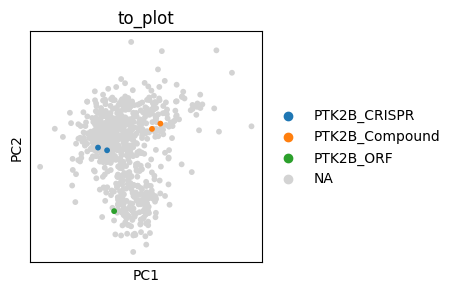

PTPN2


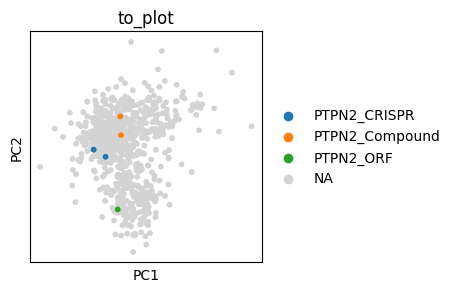

RET


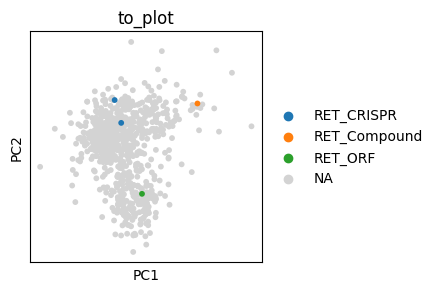

RGS4


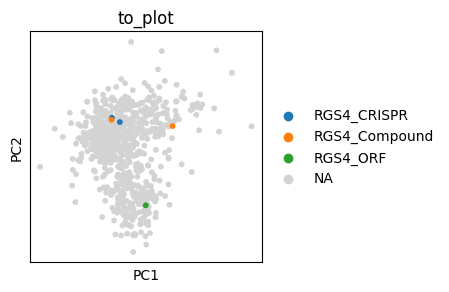

RNASE1


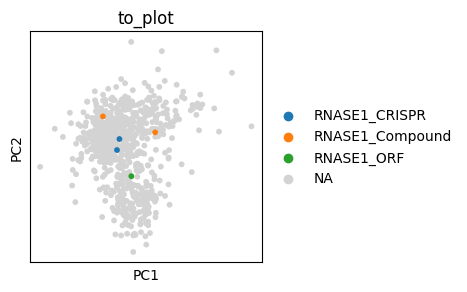

RPL23A


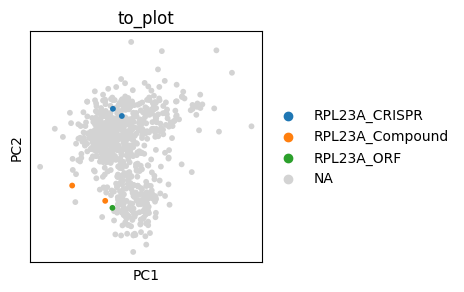

RPL3


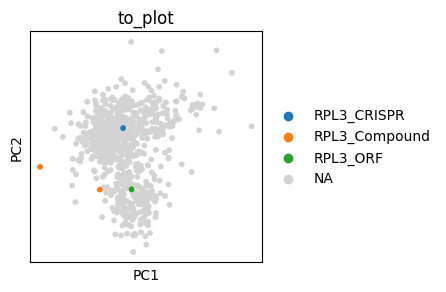

S100B


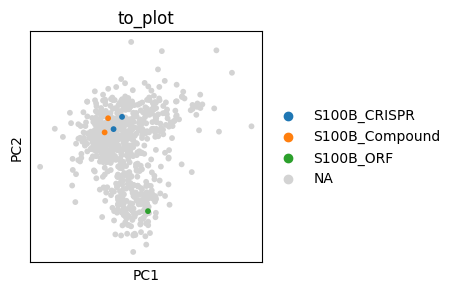

S1PR1


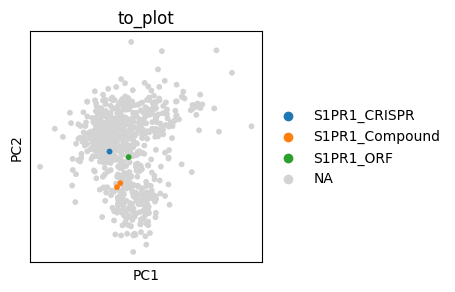

S1PR2


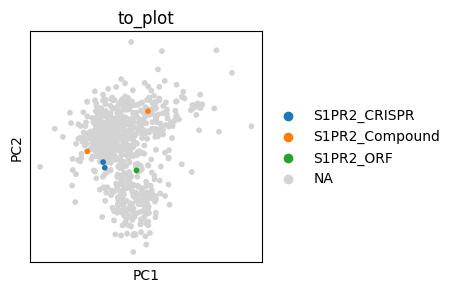

S1PR4


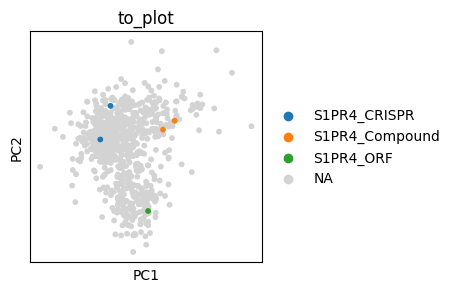

SCNN1G


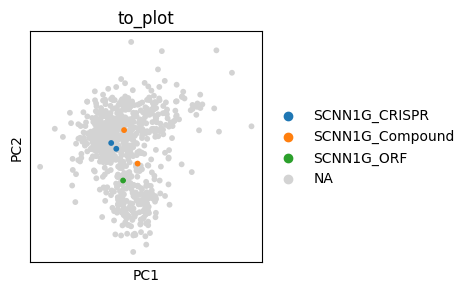

SIRT2


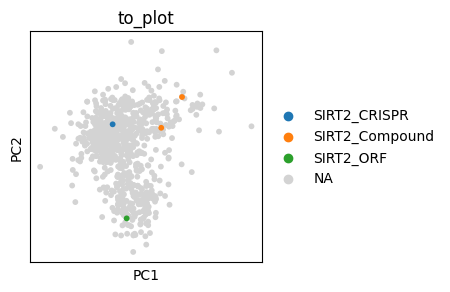

SLC29A1


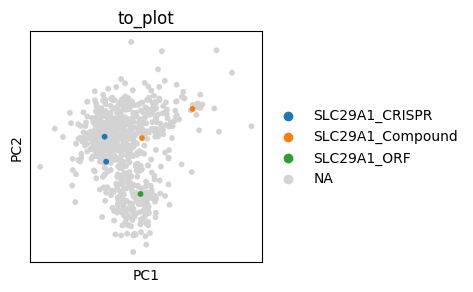

SLC7A11


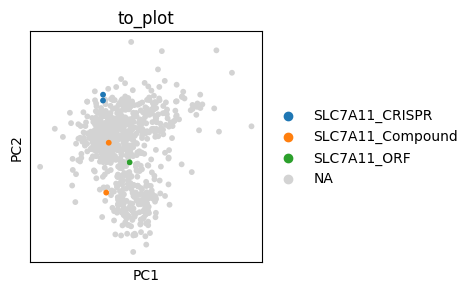

SLCO2B1


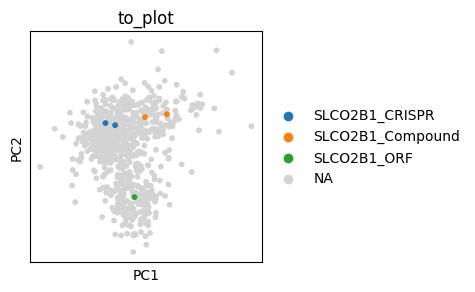

SSTR2


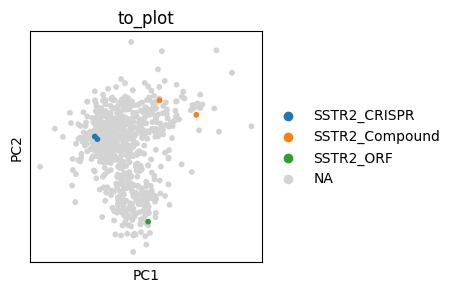

TBXAS1


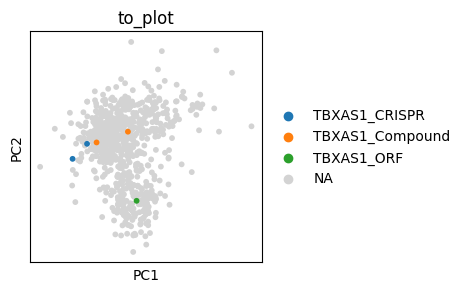

TGFBR1


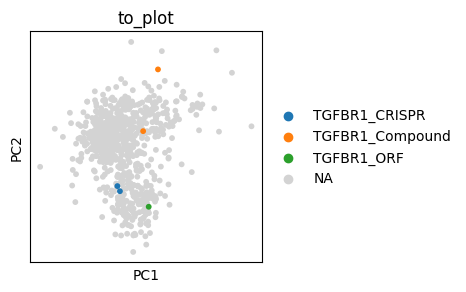

TGM2


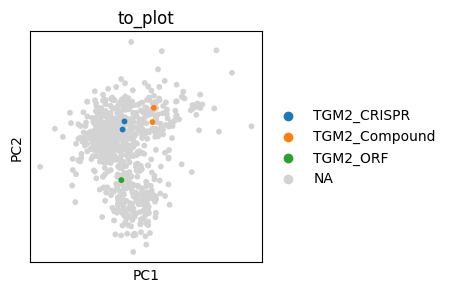

TNF


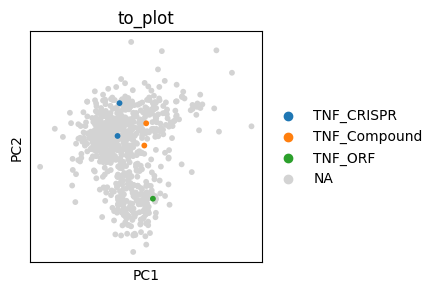

TNNC1


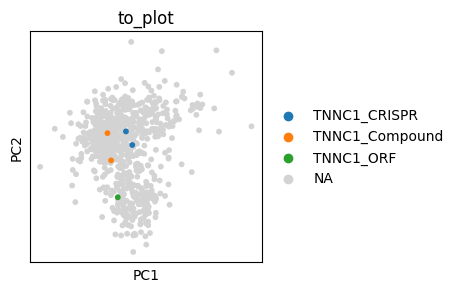

TUBB


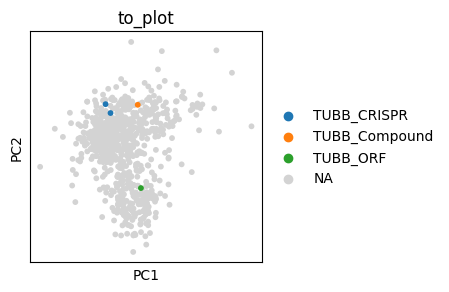

TUBB3


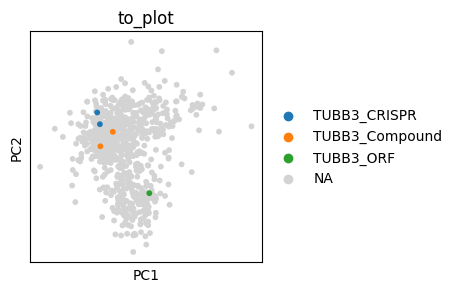

TUBB4B


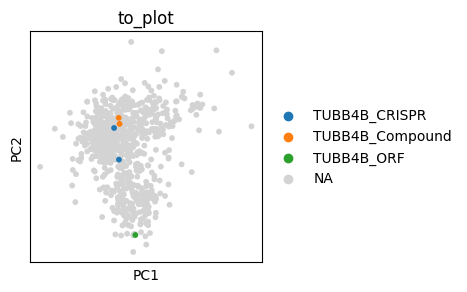

UGT1A9


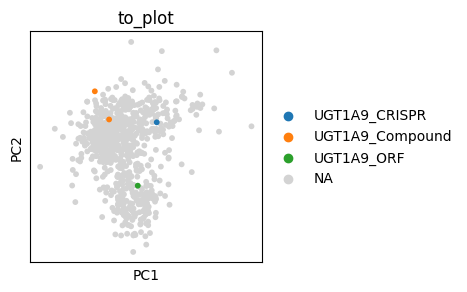

USP1


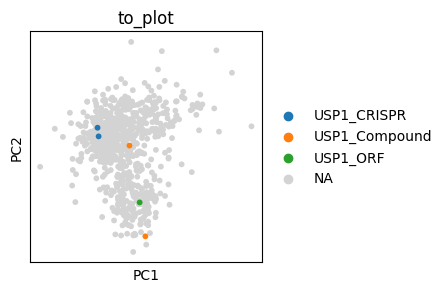

VEGFA


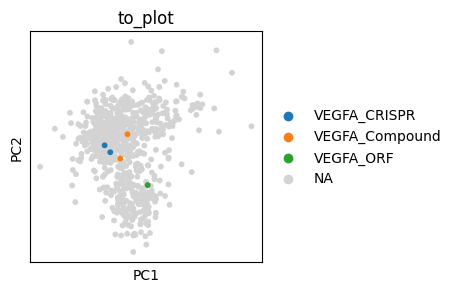

In [330]:
for gene_unique in unique_genes:
    print(gene_unique)
    to_plot = [f"{gene}_{pert_type}" if gene==gene_unique else None for pert_type, gene in zip(adata.obs.PERT_TYPE, adata.obs.GENE) ]
    adata.obs["to_plot"] = to_plot
    adata.obs["to_plot"] = adata.obs["to_plot"].astype("category")
    sc.pl.pca(adata, color="to_plot", s=70)

Compounds to leave out (mostly CRISPR)

* ADRA2B: leave out one crispr
* AKRAB1: leave out one crispr
* ALDH2: leave out one crispr
* ALK leave out crispr
* ANXA1 leave out cpd
* ASIC leave out a crispr
* CACNA2D3 leave out a crispr
* CACNAB4 leave out CPD
* COMT leave out CRISPR
* CYP1A2 leave out CRISPR
* CYP1A4 leave out CRISPR
* ITGB2 leave out ORF
* NAMPT leave out CRISPR
* OPRL1 leave out CRISPR
* OPRM1 leave out CRISPR
* PTGIR leave out CRISPR
* S100B leave out CRISPR
* TUBB4B leave out CRISPR
* VEGFA leave out CRISPR